In [184]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from skimage.feature import corner_harris, corner_peaks
from sklearn.svm import SVC
import matplotlib.pyplot as plt
# Parameters
def create_model(writer_num):
    img_size = (128, 128)
    data_dir = 'signatures'
    org_path = os.path.join(data_dir, 'full_org')
    forg_path = os.path.join(data_dir, 'full_forg')
    random_state = 42
    
    # Load Images
    def load_images(folder, label,writer_num,prefix):
        images, labels = [], []
        #for filename in os.listdir(folder):
        for j in range (1,25):
            filename = f"{prefix}_{writer_num}_{j}.png"
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
        return images, labels
    
    org_images, org_labels = load_images(org_path, 0,writer_num,'original')  # Label 0 for genuine
    forg_images, forg_labels = load_images(forg_path, 1,writer_num,'forgeries')  # Label 1 for forged
    
    images = np.array(org_images + forg_images)
    labels = np.array(org_labels + forg_labels)
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    
    # Data Augmentation
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    datagen.fit(X_train.reshape(-1, *img_size, 1))
    # Handcrafted Feature Extraction with Harris Corner Detection
    def extract_features(images):
        features = []
        for img in images:
            # Local Binary Pattern (Texture Feature)
            lbp = local_binary_pattern(img, P=1, R=4, method="uniform").flatten()
            
            # GLCM Contrast (Texture Feature)
            glcm = graycomatrix(img, distances=[1], angles=[0], symmetric=True, normed=True)
            contrast = graycoprops(glcm, prop='contrast')[0, 0]
            
            # Statistical Features
            mean = img.mean()
            std = img.std()
            
            # Harris Corner Detection (Geometric Feature)
            corners = corner_harris(img)
            corner_count = np.sum(corners > 0.01 * corners.max())  # Counting significant corners
            
            # Combine all features
            #features.append(np.hstack([lbp.mean(), lbp.std(), contrast, mean, std,corner_count]))
            features.append(np.hstack([lbp.mean()]))
        return np.array(features) 

        
    #Extract features for training, validation, and testing sets
    train_features = extract_features(X_train)
    val_features = extract_features(X_val)
    test_features = extract_features(X_test)
    a = extract_features(images)
    
    # Feature Scaling
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)
    a = scaler.transform(a)
    
    # SVM Model Training
    svm = SVC(kernel='linear', probability=True, random_state=random_state)
    svm.fit(train_features, y_train)
    
    # SVM Prediction and Evaluation
    y_pred_svm = svm.predict(a)
    accuracy = (accuracy_score(labels, y_pred_svm))
    return [svm,scaler,accuracy]

models = []
for i in range(1,56):
    models.append(create_model(i))
    print(i,end=" ")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 

55


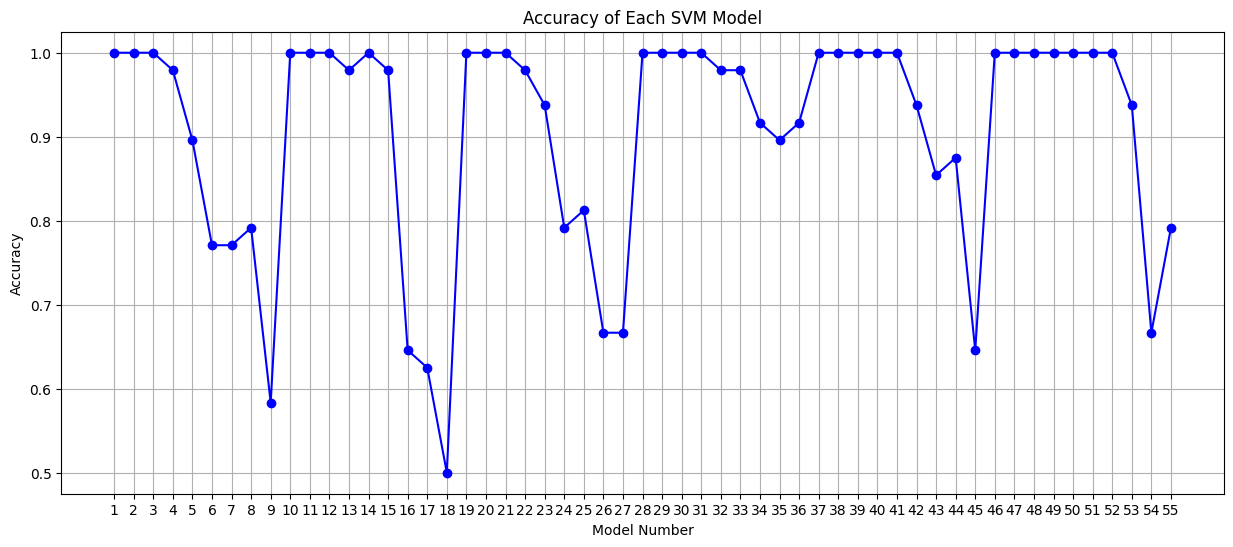

In [185]:
accuracies=[]
suma=0
for i in range(55):
    suma+=models[i][2]
    accuracies.append(models[i][2])
print(len(accuracies))
plt.figure(figsize=(15, 6))
plt.plot(range(1, 56), accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy of Each SVM Model")
plt.xlabel("Model Number")
plt.ylabel("Accuracy")
plt.xticks(range(1, 56))  # Ensuring the x-axis has each model number
plt.grid(True)
plt.show()

In [186]:
suma/55

0.9049242424242425

In [187]:
import joblib
import os

# Directory to save the models
model_dir = "svm_models"
os.makedirs(model_dir, exist_ok=True)

# Save each model with a unique filename
for i in range(55):
    model_path = os.path.join(model_dir, f"signature_classifier_writer_{i+1}.joblib")
    joblib.dump(models[i][0], model_path)
    model_path = os.path.join(model_dir, f"signature_scaler_writer_{i+1}.joblib")
    joblib.dump(models[i][1], model_path)

print(f"All models saved in '{model_dir}'")


All models saved in 'svm_models'
